# Reinforcement Learning Implementations

## Reinforcement Learning (RL): 

Reinforcement learning is an area of machine learning concerned with how software agents ought to take actions in an environment in order to maximize the notion of cumulative reward. Reinforcement learning is one of three basic machine learning paradigms, alongside supervised learning and unsupervised learning.

## Immidiate RL

In this type of RL, we have only one state and we have a set of possible actions. We try to find the best possible action to take in the given state.

We will try to understand it using the Multi-Armed Bandit problem.

## Multi-Armed Bandit Problem

In this problem, we have a slot machine with $k$ arms. Each arm has a different probability of giving a reward. We have to find the arm with the highest probability of giving a reward. We will try to find the best arm using the following algorithms:

1. Epsilon-Greedy
2. UCB
3. Gradient Bandit


### 1. Epsilon-Greedy

In Episilon-Greedy, we have a parameter $\epsilon$ which is the probability of choosing a random arm. We will choose the arm with the highest average reward with probability $1-\epsilon$.

So Basically, we will choose a random arm with probability $\epsilon$ and the best arm with probability $1-\epsilon$. On the basis of the reward we get, we will update the estimated value of the arm.

This helps us to explore the other arms as well as compared to a standard Greedy algorithm.

We are dealing with the case of Stationary Rewards below in the code i.e. the reward probability distributions are not changing with time.

### 2. UCB

In UCB, we will choose the arm with the highest Upper Confidence Bound. The Upper Confidence Bound is given by:

$$UCB = \hat{Q}(a) + c\sqrt{\frac{\ln t}{N(a)}}$$

where $\hat{Q}(a)$ is the estimated value of the arm $a$, $c$ is a constant and $N(a)$ is the number of times the arm $a$ has been chosen.

UCB is introduced as it also allows exploring. It increases the drive for exploration as if an action has been explored very less number of times, the UCB value for that action would be high as the denominator would be high in the second term. It also works well for non-stationary rewards.

### 3. Gradient Bandit

In Gradient Bandit, we will choose the arm with the highest probability. The probability of choosing an arm is given by:

$$P(a) = \frac{e^{\hat{H}(a)}}{\sum_{b}e^{\hat{H}(b)}}$$

where $\hat{H}(a)$ is the estimated value of the arm $a$.

The estimated value of the arm $a$ is updated by the following equation:

$\hat{H}(a) = \hat{H}(a) + \alpha(R - \bar{R})(1 - P(a)) $ if $a$ is chosen

$\hat{H}(a) = \hat{H}(a) - \alpha(R - \bar{R})P(a)$ if $a$ is not chosen

where $\alpha$ is the learning rate, $R$ is the reward obtained and $\bar{R}$ is the average reward obtained so far for this action.

#### All these Algorithms have been Implemented below:

**Importing Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from tqdm.notebook import tqdm
# Ipywidgets
import ipywidgets as widgets


# DEFINING CONSTANTS
NUM_STEPS = 500

**Defining the BANDIT Class**

In [ ]:
# Class for Bandit in the Multi-Armed Bandit Problem
class MultiArmedBandit:

    def __init__(self, k, episilon=0.1, method='epsilon_greedy', c=2, alpha=0.1):

        # Episilon value
        self.episilon = episilon

        # Learning rate
        self.alpha = alpha

        # Defining the number of arms
        self.k = k

        # Defining the method
        self.method = method

        # Defining the constant for UCB
        self.c = c

        # Defining the true values of the arms
        # q_true is a vector of length k with each number explaining the mean of the probability distribution of the arm
        # Mean values are between (-5, 5)
        # Arms will have a variance of 1
        self.q_true = np.random.uniform(-5, 5, k)

        # Defining the estimated values of the arms
        self.q_est = np.zeros(k)
        
        # Defining H for gradient method
        self.h = np.ones(k)

        # Defining the number of times each arm is pulled
        self.action_count = np.zeros(k)

    def get_reward(self, arm):
        # Mean of arm
        mean = self.q_true[arm]
        # Get reward from normal distribution with mean and standard deviation 1
        reward = np.random.normal(mean, 1)
        return reward

    # Function to pull an arm
    def pull(self, a):
            
            # Pulling the arm
            reward = self.get_reward(a)

            # Updating the number of times the arm is pulled
            self.action_count[a] += 1

            # Updating the estimated value of the arm
            self.q_est[a] = self.q_est[a] + (1/self.action_count[a])*(reward - self.q_est[a])

            return reward
    
    # Function to choose an arm 
    def choose_arm(self, t):

        method = self.method
        
        if method == 'epsilon_greedy':
            # Choosing the arm with the highest estimated value
            if np.random.random() > self.episilon:
                return np.argmax(self.q_est)
            # Choosing a random arm
            else:
                return np.random.randint(self.k)

        elif method == 'greedy':
            # Choosing the arm with the highest estimated value
            return np.argmax(self.q_est)

        elif method == 'random':
            # Choosing a random arm
            return np.random.randint(self.k)

        elif method == 'UCB':
            best_arm = -1
            best_arm_value = -1
            for arm in range(self.k):
                arm_value = self.q_est[arm] + np.sqrt(self.c*np.log(t)/(self.action_count[arm] + 1e-5))
                if best_arm == -1 or arm_value > best_arm_value:
                    best_arm = arm
                    best_arm_value = arm_value
            return best_arm

        elif method == 'gradient':
            # Calculating the probabilities
            probabilities = np.exp(self.h)/np.sum(np.exp(self.h))
            # Choosing an arm
            arm = np.random.choice(np.arange(self.k), p=probabilities)
            return arm
        
        else:
            raise Exception('Invalid method')

    # Function to run the bandit problem
    def run(self, num_steps):

        # Print Current Estimates of Arms
        print('True Values of the Arms: ', self.q_true)
        print('Initial Estimates of the Arms: ', self.q_est)

        # Defining the rewards
        rewards = np.zeros(num_steps)

        estimate_history = []
        estimate_history.append(self.q_est.copy())

        # Running the bandit problem
        for i in range(num_steps):
            # Choosing an arm
            arm = self.choose_arm(i+1)
            # Pulling the arm
            reward = self.pull(arm)
            # Storing the reward
            rewards[i] = reward
            # Storing the estimated values
            estimate_history.append(self.q_est.copy())
            # Gradient Method Update
            if self.method == 'gradient':
                for a in range(self.k):
                    if a == arm:
                        self.h[a] += self.alpha*(reward - self.q_est[a])*(1 - np.exp(self.h[a])/np.sum(np.exp(self.h)))
                    else:
                        self.h[a] -= self.alpha*(reward - self.q_est[a])*(np.exp(self.h[a])/np.sum(np.exp(self.h)))

        # Print Estimated Values of Arms
        print('Estimated Values of the Arms: ', self.q_est)

        return rewards, estimate_history
    
    # Function to plot the rewards
    def plot_rewards(self, rewards):

        # Plotting the rewards
        plt.plot(rewards)
        plt.xlabel('Steps')
        plt.ylabel('Rewards')
        plt.title('Rewards vs Steps')
        plt.show()
    
    # Function to plot the estimated values of the arms vs the true values
    def plot_est(self):

        # Plotting the estimated values
        plt.scatter(np.arange(self.k), self.q_est, label='Estimated Values', color='red')
        plt.plot(self.q_est, color='red')
        # Plotting the true values as stars
        plt.scatter(np.arange(self.k),self.q_true, label='True Mean Values of the Arms', marker='*', color='blue')
        plt.plot(self.q_true, color='blue')
        
        plt.xlabel('Arms')
        plt.ylabel('Values')
        plt.title('Estimated Values vs True Values')
        plt.legend()
        plt.show()
    
    # Function to plot the number of times each arm is pulled
    def plot_action_count(self):
            
        # Plotting the number of times each arm is pulled
        plt.plot(self.action_count)
        plt.xlabel('Arms')
        plt.ylabel('Number of times each arm is pulled')
        plt.title('Number of times each arm is pulled')
        plt.show()

    # Function to plot the cumulative rewards
    def plot_cumulative_rewards(self, rewards):
            
        # Plotting the cumulative rewards
        plt.plot(np.cumsum(rewards))
        plt.xlabel('Steps')
        plt.ylabel('Cumulative Rewards')
        plt.title('Cumulative Rewards vs Steps')
        plt.show()
    
    # Function to plot the average rewards
    def plot_average_rewards(self, rewards):
            
        # Plotting the average rewards
        plt.plot(np.cumsum(rewards)/(np.arange(len(rewards))+1))
        plt.xlabel('Steps')
        plt.ylabel('Average Rewards')
        plt.title('Average Rewards vs Steps')
        plt.show()

### **Running the Epsilon-Greedy Algorithm**

In [ ]:
bandit = MultiArmedBandit(10, episilon=0.1, method='epsilon_greedy')
rewards, estimate_history = bandit.run(NUM_STEPS)

True Values of the Arms:  [ 1.6126572   4.15700303  1.5891937  -0.25114934  2.45219113 -0.22785279
 -4.43787569  0.13541582  3.25543006 -0.04614564]
Initial Estimates of the Arms:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Estimated Values of the Arms:  [ 1.52413912  4.25785095  0.80617744 -0.84732445  1.92379331 -1.63506686
 -5.31251894 -0.15988049  3.22453013 -0.07899973]


**Plotting the Average Rewards**

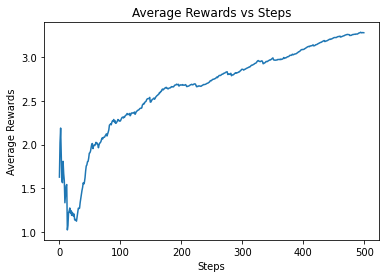

In [ ]:
bandit.plot_average_rewards(rewards)

Above Graph shows convergence at the Max-Arm as the average reward converges around the reward of the max-arm.

**Checking how close we are to finding Correct Estimations**

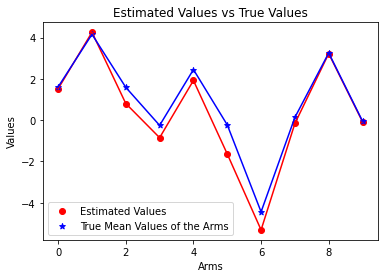

In [ ]:
bandit.plot_est()

This shows that we have estimated almost Correct Arm Values for all the arms.

**Using the Estimate History to visualise how our Estimations converged over time**

In [ ]:
len(estimate_history)

501

In [ ]:
# Using the Estimate History to visualise how our Estimations converged over time
# We will use Animation to visualise this using OpenCV
# We will use the following function to create the animation
def create_animation(estimate_history, real_values, filename='animation.mp4', fps=30, dpi=100):

    # Estimate History is a list of numpy arrays (Arrays are y-values of that Plot)
    for i in tqdm(range(len(estimate_history)), desc='Creating Images'):
        # Plot this using matplotlib and then savefig and then use OpenCV to read the image and then use it as a frame for the animation
        plt.clf()
        plt.scatter(np.arange(len(estimate_history[i])), estimate_history[i], label='Estimated Values', color='red')
        plt.plot(estimate_history[i], color='red')
        plt.scatter(np.arange(len(real_values)), real_values, label='True Mean Values of the Arms', marker='*', color='blue')
        plt.plot(real_values, color='blue')

        plt.xlabel('Arms')
        plt.ylabel('Estimate VS Real')
        plt.legend()

        plt.savefig('images/frame'+str(i)+'.png')
        plt.close()
    
    # Now we have all the frames saved as images
    # We will use OpenCV to read the images and then use them as frames for the animation
    frames = []
    
    for i in tqdm(range(len(estimate_history)), desc='Combining Images'):
        frame = cv2.imread('images/frame'+str(i)+'.png')
        frames.append(frame)
    
    # Now we have all the frames
    # We will use OpenCV to create the animation
    height, width, layers = frames[0].shape
    size = (width,height)
    out = cv2.VideoWriter(filename,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(frames)):
        out.write(frames[i])
    out.release()


In [ ]:
create_animation(estimate_history,bandit.q_true, filename='animation_e.mp4', fps=15, dpi=100)

Creating Images:   0%|          | 0/501 [00:00<?, ?it/s]

Combining Images:   0%|          | 0/501 [00:00<?, ?it/s]

#### Animation has been saved in the mp4 file

### **Running the UCB Algorithm**

In [ ]:
bandit_ucb = MultiArmedBandit(10, episilon=0.1, method='UCB')
rewards, estimate_history = bandit_ucb.run(NUM_STEPS)

True Values of the Arms:  [ 2.49080079 -3.87292647 -3.00553386 -2.23833661  1.46060106 -0.17296157
  1.78134059 -4.01987561 -1.64917859  1.4980813 ]
Initial Estimates of the Arms:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Estimated Values of the Arms:  [ 2.45119235 -3.08020458 -2.7318118  -4.21016009  1.75573439 -1.69270595
  1.90235445 -5.02123531 -1.60796958  1.05983378]


**Plotting the Average Rewards**

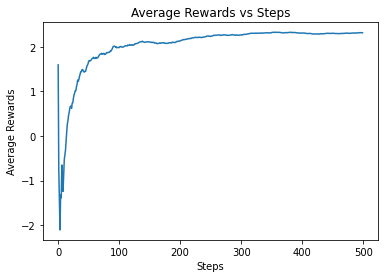

In [ ]:
bandit_ucb.plot_average_rewards(rewards)

Above Graph shows convergence at the Max-Arm as the average reward converges around the reward of the max-arm.

**Checking how close we are to finding Correct Estimations**

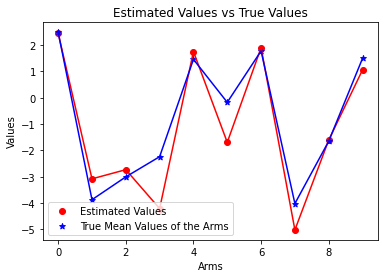

In [ ]:
bandit_ucb.plot_est()

This shows that we have estimated almost Correct Arm Values for all the arms.

**Using the Estimate History to visualise how our Estimations converged over time**

In [ ]:
len(estimate_history)

501

In [ ]:
create_animation(estimate_history,bandit_ucb.q_true, filename='animation_ucb.mp4', fps=15, dpi=100)

Creating Images:   0%|          | 0/501 [00:00<?, ?it/s]

Combining Images:   0%|          | 0/501 [00:00<?, ?it/s]

#### Animation has been saved in the mp4 file

### **Running the Gradient Bandit Algorithm**

In [ ]:
bandit_grad = MultiArmedBandit(10, alpha=0.1, method='gradient')
rewards, estimate_history = bandit_grad.run(NUM_STEPS)

True Values of the Arms:  [-0.39087773 -0.93391521  0.91491005  4.6081648   1.92682055 -1.97698689
  1.7559199   3.79643882 -4.9598888   1.9953117 ]
Initial Estimates of the Arms:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Estimated Values of the Arms:  [-1.19273136 -0.83488078  0.53778296  4.55710994  1.95492694 -1.57333324
  0.78343679  3.6624493  -5.14105524  2.07593132]


**Plotting the Average Rewards**

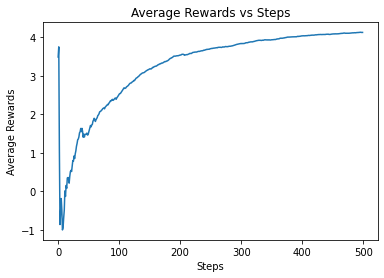

In [ ]:
bandit_grad.plot_average_rewards(rewards)

Above Graph shows convergence at the Max-Arm as the average reward converges around the reward of the max-arm.

**Checking how close we are to finding Correct Estimations**

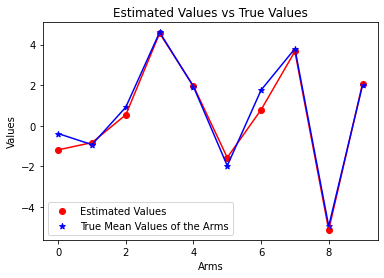

In [ ]:
bandit_grad.plot_est()

This shows that we have estimated almost Correct Arm Values for all the arms.

**Using the Estimate History to visualise how our Estimations converged over time**

In [ ]:
len(estimate_history)

501

In [ ]:
create_animation(estimate_history,bandit_grad.q_true, filename='animation_grad.mp4', fps=15, dpi=100)

Creating Images:   0%|          | 0/501 [00:00<?, ?it/s]

Combining Images:   0%|          | 0/501 [00:00<?, ?it/s]

#### Animation has been saved in the mp4 file